In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from tf_transformers.models import AlbertModel, Classification_Model
from tf_transformers.optimization import create_optimizer
from tf_transformers.core import GPUTrainer
from tf_transformers.losses import cross_entropy_loss_for_classification

In [ ]:
# Build a basic model for demonstartion purpose
config = {
    "attention_probs_dropout_prob": 0.1,
    "hidden_act": "gelu",
    "intermediate_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "embedding_size": 32,
    "initializer_range": 0.02,
    "intermediate_size": 300,
    "max_position_embeddings": 512,
    "num_attention_heads": 2,
    "attention_head_size": 16,
    "num_hidden_layers": 2,
    "type_vocab_size": 2,
    "vocab_size": 1000,
    "layer_norm_epsilon": 1e-12,
    "embedding_projection_size": 64,
}

model = AlbertModel.from_config(config)

In [ ]:
print("Model variables is {}".format(len(model.variables)))

In [ ]:
model.save_checkpoint("/tmp/albert_dummy/base_model/")

In [ ]:
# Classification model
classification_model = Classification_Model(model, num_classes=2)
classification_model = classification_model.get_model()

In [2]:
# Build a dummy dataset

minval = 0
maxval = 1000 # vocab size
n_examples = 119924
seq_length = 10
input_ids = tf.random.uniform(minval=minval, maxval=maxval, shape=(n_examples, seq_length), dtype=tf.int32)
# Binary class
labels    = tf.random.uniform(minval=0, maxval=2, shape=(n_examples,), dtype=tf.int32)
input_type_ids = tf.zeros_like(input_ids)
input_mask     = tf.ones_like(input_ids)

dataset = ({'input_ids': input_ids, 
          'input_type_ids': input_type_ids, 
          'input_mask': input_mask}, 
         {'labels': labels})
dataset = tf.data.Dataset.from_tensor_slices(dataset)

2021-08-29 10:47:35.241961: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
batch_size = 6
epochs = 1
steps_per_epoch = n_examples//batch_size
train_dataset = dataset.batch(batch_size)

In [22]:
def loss_fn(y_true_dict, y_pred_dict):
    logits = y_pred_dict['class_logits']
    labels = y_true_dict['labels']
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=tf.squeeze(labels, axis=1)))
    return loss

In [24]:
def get_optimizer(learning_rate, examples, batch_size, epochs, learning_rate_type="polynomial"):
    steps_per_epoch = int(examples / batch_size)
    num_train_steps = steps_per_epoch * epochs
    warmup_steps = int(0.1 * num_train_steps)
    print("Warmup steps", warmup_steps)
    def optimizer_fn():
        optimizer, learning_rate_fn = create_optimizer(learning_rate,
                                                  num_train_steps,
                                                  warmup_steps,
                                                  learning_rate_type=learning_rate_type )
        return optimizer
    return optimizer_fn

learning_rate = 1e-05
optimizer_fn = get_optimizer(learning_rate, 
                             n_examples, 
                             batch_size, 
                             epochs, 
                             learning_rate_type="linear")

In [25]:
optimizer = optimizer_fn()

INFO:absl:Using Adamw optimizer


In [26]:
# # Compile
keras_loss_fn = {'class_logits': loss_fn}
classification_model.compile2(optimizer=optimizer, 
                             loss=None, 
                             custom_loss=keras_loss_fn)

LR_holder = []
class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self._supports_tf_logs = True

    def on_batch_end(self, epoch, logs=None):
        if logs is None or "learning_rate" in logs:
            return
        lr = tf.keras.backend.get_value(self.model.optimizer.learning_rate)
        LR_holder.append(self.model.optimizer._decayed_lr(tf.float32))
        #logs["learning_rate"] = self.model.optimizer.lr
        logs['step_loss'] = logs['loss']
# Change steps per epoch to large value/ ignore it completely to train
# on full dataset
history = classification_model.fit(train_dataset, 
                                   epochs=epochs,
                                   steps_per_epoch=steps_per_epoch, 
                                   callbacks=[LearningRateLogger()])

19987/19987 [==============================] - 78s 4ms/step - loss: 0.6939 - class_logits_loss: 0.6939 - step_loss: 0.6939


In [29]:
warmup_steps

11992

Text(0, 0.5, 'learning Rate')

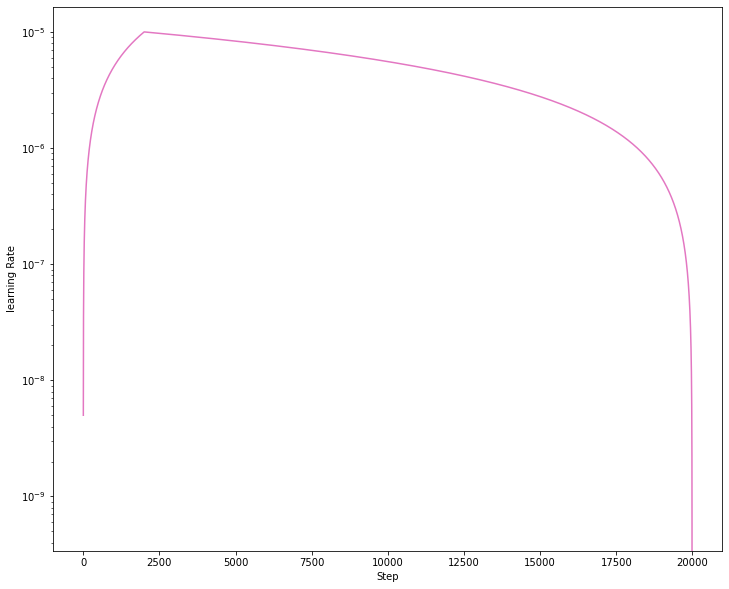

In [31]:
lr_holder_flattened = [item.numpy() for item in LR_holder]
plt.semilogy(range(len(LR_holder)), lr_holder_flattened,
           color=colors[6], label='Train')

plt.xlabel('Step')
plt.ylabel('learning Rate')

In [38]:
# Okay lets build model from scratch
def model_fn():
    model = AlbertModel.from_config(config)
    model.load_checkpoint("/tmp/albert_dummy/base_model/")
    # Classification model
    classification_model = Classification_Model(model, num_classes=2)
    classification_model = classification_model.get_model()
    return classification_model

In [50]:
trainer = GPUTrainer(distribution_strategy='off')
def loss_fn(y_true_dict, y_pred_dict):
    logits = y_pred_dict['class_logits']
    labels = y_true_dict['labels']
    loss = cross_entropy_loss_for_classification(logits=logits, labels=labels)
    return {'loss': loss}

In [51]:
model_checkpoint_dir = "/tmp/albert_dummy/classificatio_mode/"
history = trainer.run(
    model_fn = model_fn,
    optimizer_fn = optimizer_fn,
    train_dataset = train_dataset,
    train_loss_fn = loss_fn,
    epochs = epochs,
    steps_per_epoch = steps_per_epoch,
    model_checkpoint_dir=model_checkpoint_dir,
    batch_size=batch_size,
    training_loss_names=None,
    validation_loss_names=None,
    validation_dataset=None,
    validation_loss_fn=None,
    validation_interval_steps=None,
    steps_per_call=10,
    enable_xla=False,
    callbacks=None,
    callbacks_interval_steps=None,
    overwrite_checkpoint_dir=True,
    max_number_of_models=10,
    model_save_interval_steps=None,
    repeat_dataset=False,
    latest_checkpoint=None,
)

INFO:absl:Make sure `steps_per_epoch` should be less than or equal to number of batches in dataset.
INFO:absl:Policy: ----> float32
INFO:absl:Strategy: ---> <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7ffec951e1f0>
INFO:absl:Num GPU Devices: ---> 1
INFO:absl:Create model from config
INFO:absl:Successful: Model checkpoints matched and loaded from /tmp/albert_dummy/base_model/ckpt-1
INFO:absl:Using Adamw optimizer
INFO:absl:No checkpoint found in /tmp/albert_dummy/classificatio_mode/
Epoch 1/1 --- Step 10/19987 --- total examples 0:   0%|          | 0/1998 [00:00<?, ?batch /s]

Epoch 1/1 --- Step 19980/19987 --- total examples 119820: 100%|██████████| 1998/1998 [01:10<00:00, 28.27batch /s, learning_rate=6.39e-9, loss=0.692]
INFO:absl:Model saved at epoch 1


In [54]:
%load_ext tensorboard
%tensorboard --logdir=/tmp/albert_dummy/classificatio_mode/logs/train/

In [4]:
import torch

In [5]:
model = torch.nn.Linear(2, 1)
learning_rate = 1e-05
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, 
                                                steps_per_epoch=steps_per_epoch, 
                                                epochs=epochs,
                                                anneal_strategy='linear')

In [6]:
lrs = []
for i in range(steps_per_epoch):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

Text(0, 0.5, 'learning Rate')

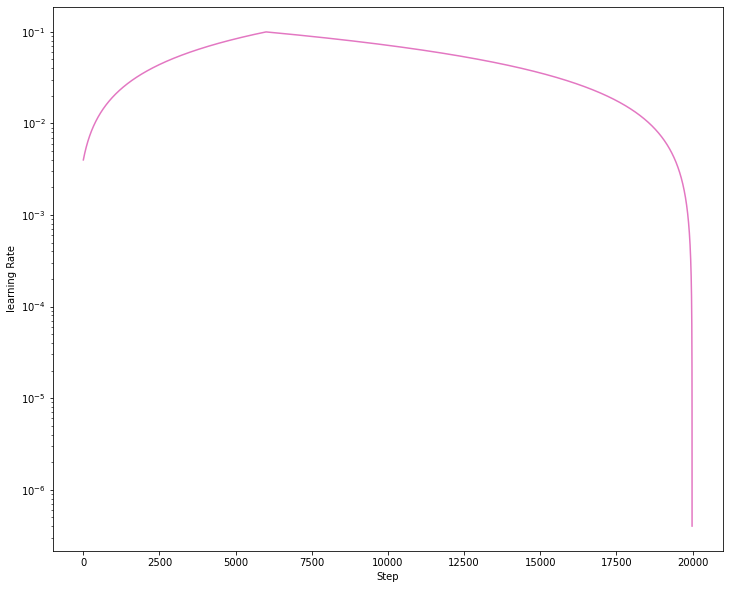

In [10]:
plt.semilogy(range(len(lrs)), lrs,
           color=colors[6], label='Train')

plt.xlabel('Step')
plt.ylabel('learning Rate')

In [26]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LambdaLR
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0,
    after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.

    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The totale number of training steps.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.

    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)

model = torch.nn.Linear(2, 1)
learning_rate = 1e-05
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=int(0.1*n_examples), num_training_steps=n_examples
            )
lrs = []
opt_steps
for i in range(steps_per_epoch):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

Text(0, 0.5, 'learning Rate')

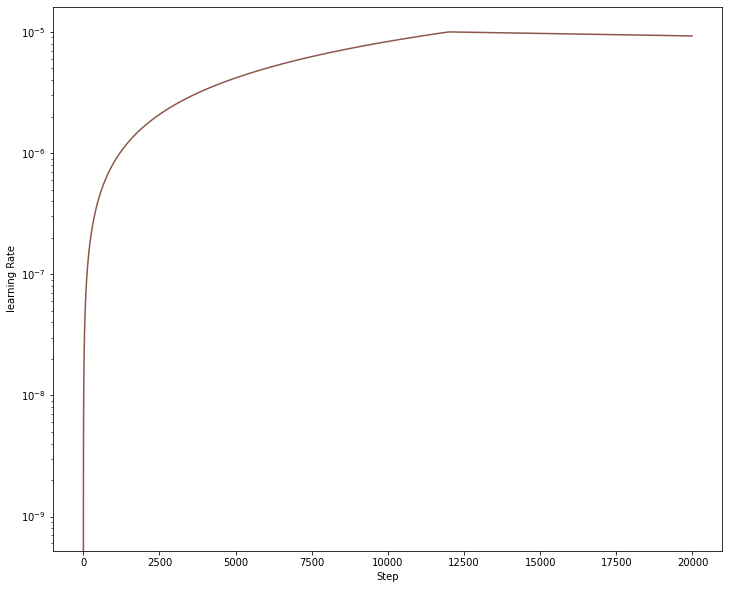

In [27]:
plt.semilogy(range(len(lrs)), lrs,
           color=colors[5], label='Train')

plt.xlabel('Step')
plt.ylabel('learning Rate')